In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage import io

from tyssue.generation import generate_ring
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec

from tyssue_taylor.adjusters.adjust_annular import prepare_tensions, adjust_parameters
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, opt_sum_lambda
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          plot_force_inference)


Using TensorFlow backend.
/home/guillaume/miniconda3/envs/taylor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/guillaume/miniconda3/envs/taylor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/guillaume/miniconda3/envs/taylor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gu

## Extraction du maillage depuis les images

Ici on utilise une version modifié de l'image brightfield où les membranes apicales et basales ont été repassées à la main.

Pour la segmentation des noyaux, on utilise l'algorithm convex star polynoms (stardist).

In [2]:
%pdb

Automatic pdb calling has been turned ON


In [3]:
! ls ../assets

CELLPROFILER_sample_image_dapi.tiff.csv
dist_at_each_f_ev
indexing.svg
pipeline_test_bfgs_opt.json
pipeline_test_energy_opt.json
pipeline_test_lm_opt.json
pipeline_test_psqp_opt.json
pipeline_test_theoritical_organo.hdf5
pipeline_test_theoritical_organo_specs.json
pipeline_test_trf_opt.json
sample_image_actin_surligned.tif
sample_image_actin.tiff
sample_image_brightfield.tiff
sample_image_dapi.tiff
star_convex_polynoms
testlog3.txt


In [14]:
brigthfield_path = '../assets/sample_image_actin_surligned.tif'
dapi_path = '../assets/sample_image_dapi.tiff'
scp_path = '../assets/star_convex_polynoms/models'


In [15]:
bright = io.imread(brigthfield_path)
dapi = io.imread(dapi_path)


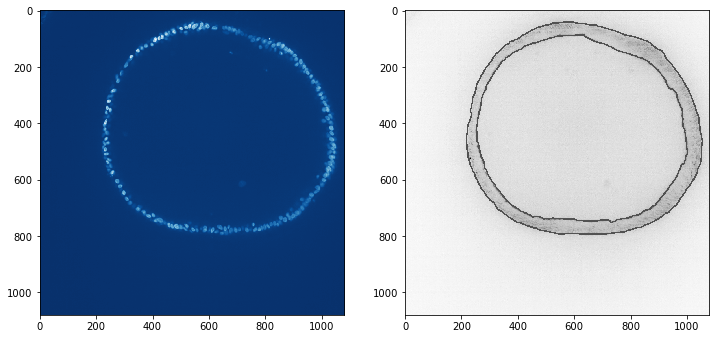

In [57]:
fig, axes = plt.subplots(1, 0)
axes[0].imshow(dapi, cmap="Blues_r")
axes[1].imshow(bright, cmap="Greys")
fig.set_size_inches(12, 12)

In [44]:
from tyssue_taylor.segmentation.segment2D import extract_membranes, _star_convex_polynoms, dist_to_coord, non_maximum_suppression

In [28]:
from glob import glob
from skimage.io import imread
from csbdeep.utils import normalize
from stardist.models import StarDist2D


In [45]:
images = sorted(glob(dapi_path))
images = list(map(imread, images))
img = normalize(images[0], 1, 99.8)
model_sc = StarDist2D(None, name="stardist_shape_completion", basedir=scp_path)
prob, dist = model_sc.predict(img)
coord = dist_to_coord(dist)
points = non_maximum_suppression(coord, prob, prob_thresh=0.4)
points = np.flip(points, 1)


Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


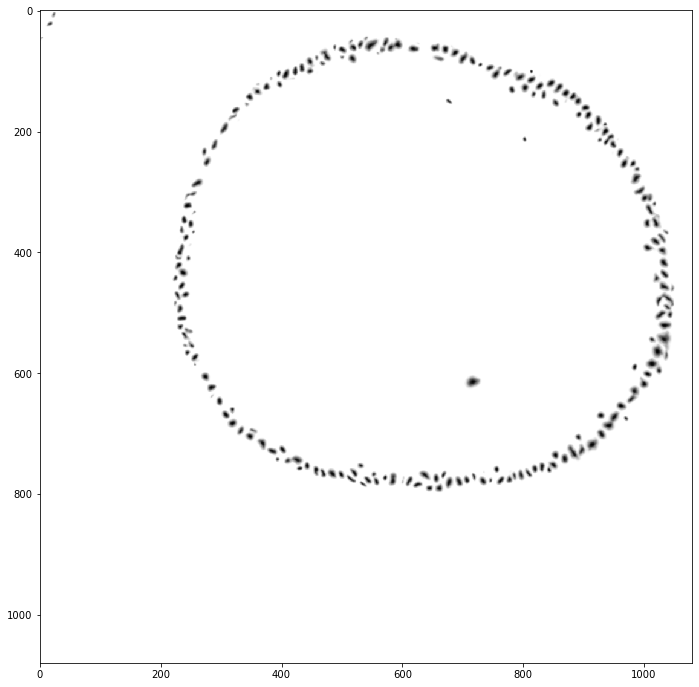

In [56]:

plt.imshow(prob, cmap="Greys")
fig = plt.gcf()
fig.set_size_inches(12, 12)
fig.savefig("prob.png")

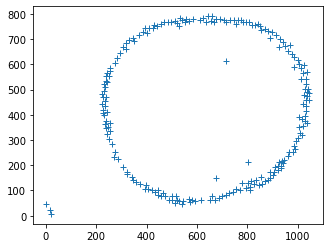

In [52]:
fig, ax = plt.subplots()
ax.plot(points[:, 0], points[:, 1], '+')
ax.set_aspect("equal")
fig.savefig('nuclei.svg')

In [59]:

#initialising the mesh
organo, inners, outers, centers = generate_ring_from_image(brigthfield_path, dapi_path,
                                                           threshold=2,
                                                           scp_model_path=scp_path,
                                                           rol_window_inside=20,
                                                           rol_window_outside=5)
Nf = organo.Nf
geom.update_all(organo)

alpha = 1.001
# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  list(alpha*organo.face_df.area.values), 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
geom.update_all(organo)
normalize_scale(organo, geom)
geom.update_all(organo)
inners = inners[:int(2830/2)]
outers = outers[:int(outers.shape[0]/2)]

organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]


Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


Reseting column is_alive of the face dataset with new specs
Reseting column ux of the edge dataset with new specs
Reseting column uy of the edge dataset with new specs
Reseting column is_active of the vert dataset with new specs


## Initialisation avec la méthode d'inférence de forces

### Recherche de la valeur optimale pour la somme des tensions

In [7]:
start = time.time()
opt_cst = opt_sum_lambda(organo)
end = time.time() - start
print("Solving time = ", end,
      "   |   x* = ", opt_cst)

Solving time =  2916.183737039566    |   x* =  0.005184834948674213


### Application de la méthode d'inférence de force

Les tensions et les aires de préférences sont inférées. Plus précisément, les termes $A-A_0$ sont inférés.

En plus des contraintes usuelles de l'inférence de forces, on ajoute une contrainte par cellule imposant que la somme des tensions sur ses edges soit égale à une constante $C$.

Pour fixer cette constante, on utilise la formule de Farhadifar où les paramètres $\overline{\Lambda}$ et $\overline{A_0}$ sont calculé dans un organoïde symétrique (aussi appelé régulié).

Le système d'inférence de force est composé de $5N_f$ lignes et $4N_f+1$ colonnes. On le résoud avec NNLS pour garantir la non-négativité des tensions.


Distance from th org to exp org:  0.0


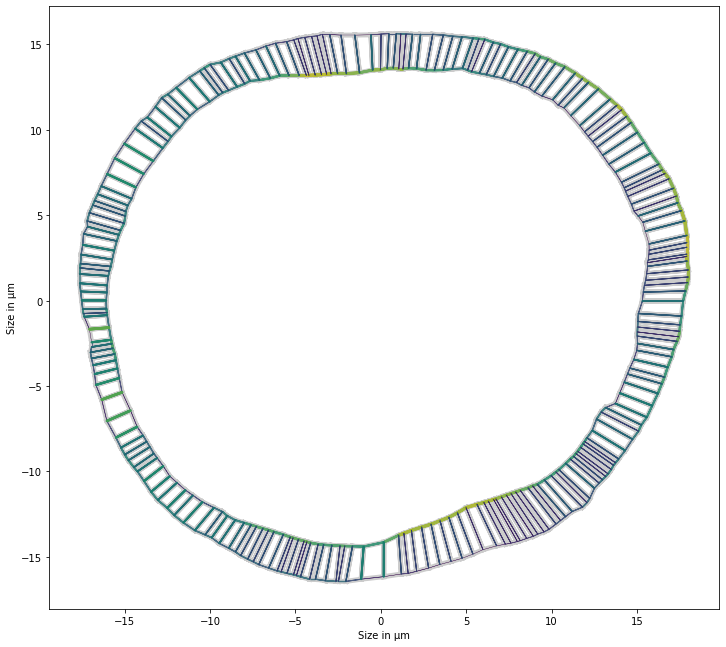

In [61]:
opt_cst = 0.005184834948674213

#Calling force inference
fi_init = infer_forces(organo, t_sum=opt_cst)
fi_t = fi_init['tensions']
fi_a = fi_init['areas']
organo_fi = organo.copy()
#Setting fi results in the mesh
organo_fi.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo_fi, fi_t)
organo_fi.face_df.loc[:, 'prefered_area'] = organo_fi.face_df.area + fi_a[:-1]
organo_fi.settings['lumen_prefered_vol'] = organo_fi.settings['lumen_volume'] + fi_a[-1]
#Solving for energy min and displaying

Solver.find_energy_min(organo_fi, geom, model)
print_tensions(organo_fi, organo)
print('\nDistance from th org to exp org: ', np.sum(_distance(organo_fi, organo)))

In [19]:
from tyssue.draw import sheet_view


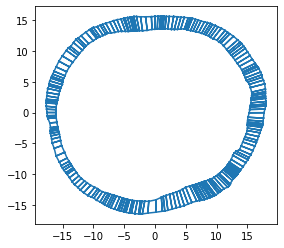

In [25]:
fig, ax = sheet_view(organo, mode="quick")


In [22]:
fig.savefig('exemple_segmentation.svg')

In [31]:
organo.edge_df["segment"].unique()

array(['apical', 'basal', 'lateral'], dtype=object)

In [58]:
organo.edge_df["visible"] = organo.edge_df["segment"] != "lateral"
fig, ax = sheet_view(
    organo,
    mode="2D", 
    vert={"visible": False},
    edge={"width": (organo.edge_df["segment"] != "lateral").astype(float)*1})

NameError: name 'organo' is not defined

> <ipython-input-58-a94e21531f16>(1)<module>()
----> 1 organo.edge_df["visible"] = organo.edge_df["segment"] != "lateral"
      2 fig, ax = sheet_view(
      3     organo,
      4     mode="2D",
      5     vert={"visible": False},

ipdb> c


In [38]:
fig.savefig("contours.svg")

In [29]:
from tyssue.draw.plt_draw import draw_edge

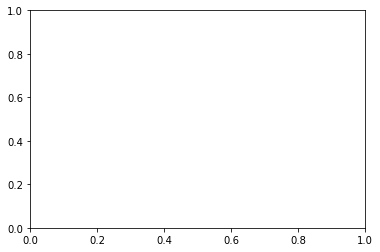

In [34]:
fig, ax = plt.subplots()
organo.edge_df = organo.edge_df[organo.edge_df["segment"] != "lateral"]
draw_edge(organo, coords=list('xy'), ax=ax)

In [16]:
fig = plt.gcf()

<Figure size 432x288 with 0 Axes>

In [17]:
fig

<Figure size 432x288 with 0 Axes>

## Procédure de recalage

La résolution du problème de recalage est faite avec Levenberg-Marquardt.

In [23]:
start = time.time()
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-4, 'verbose': 0}

fi_init_array = np.r_[fi_t, organo_fi.face_df.area + fi_a[:-1],
                      organo_fi.settings['lumen_volume'] + fi_a[-1]]

rec_res = adjust_parameters(organo, fi_init_array, **lm_opt)
end = time.time() - start
print("Solving time = ", end,
      "   |   f(x*) = ", np.sum(rec_res.fun))

Solving time =  1646.9174559116364    |   f(x*) =  0.0
